In [8]:
import json
import numpy as np
from GRID import GRID
import matplotlib.pyplot as plt
import  sys

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [9]:

var = 'Vx'
Uvar = 'Ux'
# Keys = ['0']
Keys = ['0', '1', '2', '3', '4', '5', '6']
StationTicks = np.arange( 0, len(Keys) )
StationLabels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [10]:
# float

# parameters json file and grid configuaration
jsonsFile = open( "../paramsDir/paramsCGFDM3D_fp32.json" )
params = json.load( jsonsFile )
grid = GRID( params )

DT = params["DT"]
TMAX = params["TMAX"]
NT = int( params["TMAX"] / params["DT"] ) - 1
print("NT=%d" % NT)
t = np.linspace( 0, params["TMAX"], NT )

# stations json file
stationFile = open( "../stationsDir/station.json" )
stationDir = json.load( stationFile )
station = stationDir["station(point)"]

fileName = "../%s/station" % params["out"]

WAVESIZE = 9

mpiX = -1
mpiY = -1
mpiZ = -1

PX = grid.PX
PY = grid.PY
PZ = grid.PZ

stationNum = np.zeros( [PZ, PY, PX], dtype = 'int32' ) 
stationData = { }

seq = 0


varDir = { "Vx" : 0, "Vy" : 1, "Vz" : 2, "Txx" : 3, "Tyy" : 4, "Tzz" : 5, "Txy" : 6, "Txz" : 7, "Tyz" : 8 }
varId = varDir[var]


# stations loop
for index in station.values( ):
	X = index[0]
	Y = index[1]
	Z = index[2]

	# MPI block loop
	for mpiZ in range( grid.PZ ):
		for mpiY in range( grid.PY ):
			for mpiX in range( grid.PX ):
				thisX = X - grid.frontNX[mpiX] + grid.halo
				thisY = Y - grid.frontNY[mpiY] + grid.halo
				thisZ = Z - grid.frontNZ[mpiZ] + grid.halo
				if thisX >= grid.halo and thisX < grid._nx[mpiX] and \
					thisY >= grid.halo and thisY < grid._ny[mpiY] and \
						thisZ >= grid.halo and thisZ < grid._nz[mpiZ]:
					stationNum[mpiZ, mpiY, mpiX] += 1	# indicate station number in this MPI block

stationForDrawNum = len( Keys )
U0 = np.zeros( [ stationForDrawNum, NT ] )
Ux = np.zeros( [ stationForDrawNum, NT ] )
Uy = np.zeros( [ stationForDrawNum, NT ] )
Uz = np.zeros( [ stationForDrawNum, NT ] )

stationKeyNum = { }

num = 0
for mpiZ in range( grid.PZ ):
	for mpiY in range( grid.PY ):
		for mpiX in range( grid.PX ):
			if stationNum[mpiZ, mpiY, mpiX] != 0:
				FileName = "%s_mpi_%d_%d_%d.bin" % ( fileName, mpiX, mpiY, mpiZ )
				File = open( FileName, "rb" )
				print( FileName )
				count = stationNum[mpiZ, mpiY, mpiX]	# station number
				XIndex = np.fromfile( File, dtype='int32', count = count )
				YIndex = np.fromfile( File, dtype='int32', count = count )
				ZIndex = np.fromfile( File, dtype='int32', count = count )

				count = NT * stationNum[mpiZ, mpiY, mpiX] * WAVESIZE
				data = np.fromfile( File, dtype='float32', count = count )
				dataRe = np.reshape( data, ( WAVESIZE, stationNum[mpiZ, mpiY, mpiX], NT ) )	# station wave data
				stationData[( mpiX, mpiY, mpiZ )] = dataRe
				for key in Keys:
					xidx = station[key][0]	# x, y, z grid points location
					yidx = station[key][1]
					zidx = station[key][2]
					print( "key = %s, X = %d, Y = %d, Z = %d" % ( key, xidx, yidx, zidx ) )
					for i in range( stationNum[mpiZ, mpiY, mpiX] ):
						Ux_ = np.zeros( NT )
						Uy_ = np.zeros( NT )
						Uz_ = np.zeros( NT )

						'''
						UxSum = 0.0
						UySum = 0.0
						UzSum = 0.0
						for it in range( 1, NT ):
							UxSum += ( dataRe[0, i, it] + dataRe[0, i, it] ) * DT * 0.5
							UySum += ( dataRe[1, i, it] + dataRe[1, i, it] ) * DT * 0.5
							UzSum += ( dataRe[2, i, it] + dataRe[2, i, it] ) * DT * 0.5
							Ux_[it] = UxSum
							Uy_[it] = UySum
							Uz_[it] = UzSum
						'''
						Ux_ = dataRe[0, i, :]	# Vx
						Uy_ = dataRe[1, i, :]	# Vy
						Uz_ = dataRe[2, i, :]	# Vz

						if xidx == XIndex[i] and yidx == YIndex[i] and zidx == ZIndex[i]:
							Ux[num] = Ux_
							Uy[num] = Uy_
							Uz[num] = Uz_

							stationKeyNum[key] = num
							num += 1


if Uvar == 'Ux':
	U0 = Ux
else:
	if Uvar == 'Uy':
		U0 = Uy
	else:
		if Uvar == 'Uz':
			U0 = Uz	
		else:
			U0 = U0 + 1
vmax = np.max( np.abs( U0 ) )

NT=2999
../output/CGFDM3D_fp32/station_mpi_0_1_0.bin
key = 0, X = 249, Y = 199, Z = 299
key = 1, X = 299, Y = 199, Z = 299
key = 2, X = 349, Y = 199, Z = 299
key = 3, X = 399, Y = 199, Z = 299
key = 4, X = 449, Y = 199, Z = 299
key = 5, X = 499, Y = 199, Z = 299
key = 6, X = 549, Y = 199, Z = 299


In [11]:
# half

# parameters json file and grid configuaration
jsonsFile = open( "../paramsDir/paramsCGFDM3D_half2.json" )
params = json.load( jsonsFile )
grid = GRID( params )

DT = params["DT"]
NT = int( params["TMAX"] / params["DT"] ) - 1
print("NT=%d" % NT)
t = np.linspace( 0, params["TMAX"], NT )

# stations json file
stationFile = open( "../stationsDir/station.json" )
stationDir = json.load( stationFile )
station = stationDir["station(point)"]

fileName = "../%s/station" % params["out"]

WAVESIZE = 9

mpiX = -1
mpiY = -1
mpiZ = -1

PX = grid.PX
PY = grid.PY
PZ = grid.PZ

stationNum = np.zeros( [PZ, PY, PX], dtype = 'int32' ) 
stationData = { }

seq = 0


varDir = { "Vx" : 0, "Vy" : 1, "Vz" : 2, "Txx" : 3, "Tyy" : 4, "Tzz" : 5, "Txy" : 6, "Txz" : 7, "Tyz" : 8 }
varId = varDir[var]


# stations loop
for index in station.values( ):
	X = index[0]
	Y = index[1]
	Z = index[2]

	# MPI block loop
	for mpiZ in range( grid.PZ ):
		for mpiY in range( grid.PY ):
			for mpiX in range( grid.PX ):
				thisX = X - grid.frontNX[mpiX] + grid.halo
				thisY = Y - grid.frontNY[mpiY] + grid.halo
				thisZ = Z - grid.frontNZ[mpiZ] + grid.halo
				if thisX >= grid.halo and thisX < grid._nx[mpiX] and \
					thisY >= grid.halo and thisY < grid._ny[mpiY] and \
						thisZ >= grid.halo and thisZ < grid._nz[mpiZ]:
					stationNum[mpiZ, mpiY, mpiX] += 1	# indicate station number in this MPI block

stationForDrawNum = len( Keys )
U  = np.zeros( [ stationForDrawNum, NT ] )
Ux = np.zeros( [ stationForDrawNum, NT ] )
Uy = np.zeros( [ stationForDrawNum, NT ] )
Uz = np.zeros( [ stationForDrawNum, NT ] )

stationKeyNum = { }

num = 0
for mpiZ in range( grid.PZ ):
	for mpiY in range( grid.PY ):
		for mpiX in range( grid.PX ):
			if stationNum[mpiZ, mpiY, mpiX] != 0:
				FileName = "%s_mpi_%d_%d_%d.bin" % ( fileName, mpiX, mpiY, mpiZ )
				File = open( FileName, "rb" )
				print( FileName )
				count = stationNum[mpiZ, mpiY, mpiX]	# station number
				XIndex = np.fromfile( File, dtype='int32', count = count )
				YIndex = np.fromfile( File, dtype='int32', count = count )
				ZIndex = np.fromfile( File, dtype='int32', count = count )

				count = NT * stationNum[mpiZ, mpiY, mpiX] * WAVESIZE
				data = np.fromfile( File, dtype='float32', count = count )
				dataRe = np.reshape( data, ( WAVESIZE, stationNum[mpiZ, mpiY, mpiX], NT ) )	# station wave data
				stationData[( mpiX, mpiY, mpiZ )] = dataRe
				for key in Keys:
					xidx = station[key][0]	# x, y, z grid points location
					yidx = station[key][1]
					zidx = station[key][2]
					print( "key = %s, X = %d, Y = %d, Z = %d" % ( key, xidx, yidx, zidx ) )
					for i in range( stationNum[mpiZ, mpiY, mpiX] ):
						Ux_ = np.zeros( NT )
						Uy_ = np.zeros( NT )
						Uz_ = np.zeros( NT )

						'''
						UxSum = 0.0
						UySum = 0.0
						UzSum = 0.0
						for it in range( 1, NT ):
							UxSum += ( dataRe[0, i, it] + dataRe[0, i, it] ) * DT * 0.5
							UySum += ( dataRe[1, i, it] + dataRe[1, i, it] ) * DT * 0.5
							UzSum += ( dataRe[2, i, it] + dataRe[2, i, it] ) * DT * 0.5
							Ux_[it] = UxSum
							Uy_[it] = UySum
							Uz_[it] = UzSum
						'''
						Ux_ = dataRe[0, i, :]	# Vx
						Uy_ = dataRe[1, i, :]	# Vy
						Uz_ = dataRe[2, i, :]	# Vz

						if xidx == XIndex[i] and yidx == YIndex[i] and zidx == ZIndex[i]:
							Ux[num] = Ux_
							Uy[num] = Uy_
							Uz[num] = Uz_

							stationKeyNum[key] = num
							num += 1


if Uvar == 'Ux':
	U = Ux
else:
	if Uvar == 'Uy':
		U = Uy
	else:
		if Uvar == 'Uz':
			U = Uz	
		else:
			U = U + 1
vmax = np.max( np.abs( U ) )



NT=2999
../output/CGFDM3D_half2/station_mpi_0_1_0.bin
key = 0, X = 249, Y = 199, Z = 299
key = 1, X = 299, Y = 199, Z = 299
key = 2, X = 349, Y = 199, Z = 299
key = 3, X = 399, Y = 199, Z = 299
key = 4, X = 449, Y = 199, Z = 299
key = 5, X = 499, Y = 199, Z = 299
key = 6, X = 549, Y = 199, Z = 299


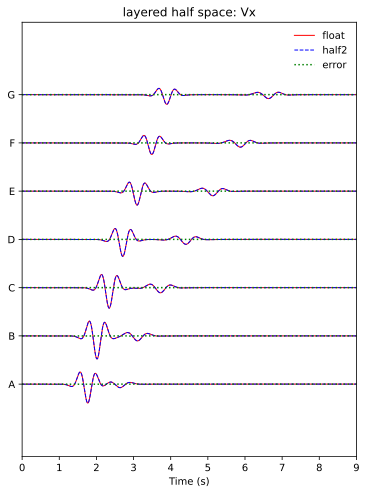

In [12]:
fig, ax = plt.subplots(figsize=(6, 8))
base = 0
stride = 0.05
mul = 10
flag = True

for key in station.keys( ):
	#print( key )
	for iKey in Keys:
		if key == iKey:
			# print( key )

			i = stationKeyNum[key]
			# print(U[i].shape)


			ax.plot( t, U0[i]+base, color='r', linewidth=1, ls = '-', label="float")
			ax.plot( t, U[i]+base, color='b', linewidth=1, ls = '--', label="half2")
			# ax.plot( t, (U0[i] - U[i]) * mul + base , color = 'g', ls = ':', label="error")
			ax.plot( t, (U0[i] - U[i]) + base , color = 'g', ls = ':', label="error")
			# ax.scatter( t, U0[i] - U[i] , color = 'g', s=0.1, label="res")
			# ax.grid()

			if (flag == True):
				ax.legend(loc="upper right", fontsize="medium", frameon=False)
				
				flag = False
			
			
			# ax.set_title("sta" + str(key))
			base += stride

			break

ax.set_xlabel("Time (s)")

# ax.set_ylabel("Vx")
ax.set_title("layered half space: %s" % var)
# ax.set_title("Gaussian hill model: %s" % var)
ax.set_xlim([0, TMAX])	
ax.set_ylim( [-1.5*stride, base + stride/2] )	
ax.set_yticks( StationTicks[:len(Keys)] * stride,  StationLabels[:len(Keys)])
# plt.savefig("imagesDir/%s.png" % var, dpi=500, bbox_inches = "tight")
# ax.set_yticklabels( ["", "A", "B", "C", "D", "E", "F", "G", ""] )	


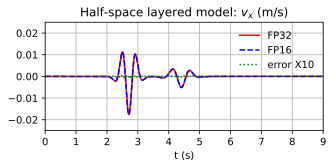

In [13]:
fig, ax = plt.subplots(figsize=(5, 2))
# base = 0
# stride = 0.135
mul = 10
flag = True

for key in station.keys( ):
	#print( key )
	for iKey in Keys:
		if key == iKey and key == "3":
			# print( key )
			
			i = stationKeyNum[key]
			# print(U[i].shape)

			ax.plot( t, U0[i], color='r', ls = '-', label="FP32")
			ax.plot( t, U[i], color='b', ls = '--', label="FP16")
			# ax.plot( t, (U0[i] - U[i]) * mul + base , color = 'g', ls = ':', label="error")
			ax.plot( t, (U0[i] - U[i])*10, color = 'g', ls = ':', label="error X10")
			# ax.scatter( t, U0[i] - U[i] , color = 'g', s=0.1, label="res")
			# ax.grid()

			if (flag == True):
				ax.legend(loc="upper right", fontsize="medium", frameon=False)
				
				flag = False
			
			
			# ax.set_title("sta" + str(key))
			# base += stride

			break

ax.set_xlabel("t (s)")
# ax.set_ylabel("Vx")
if var == 'Vx':
	ax.set_title("Half-space layered model: $v_x$ (m/s)")
if var == 'Vz':
	ax.set_title("Half-space layered model: $v_z$ (m/s)")
# ax.set_title("Half-space layered model: $v_z$ (m/s)")
ax.set_xlim([0, TMAX])	
ax.set_ylim( [-0.025, 0.025] )
ax.grid()
# ax.set_yticklabels(["", -0.02, "","0","",0.02,""])
# ax.set_yticks( StationTicks[:len(Keys)] * stride,  StationLabels[:len(Keys)])
plt.savefig("imagesDir/%s_single.pdf" % var, dpi=500, bbox_inches = "tight")
# ax.set_yticklabels( ["", "A", "B", "C", "D", "E", "F", "G", ""] )	

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.fft import fft, fftfreq


# # 采样频率
# fs = 50

# N = len(t)
# yf = fft(U0[0] - U[0])
# xf = fftfreq(N, 1 / fs)[:N // 2]

# # 画图
# # plt.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# # plt.plot(xf, 2.0 / N * yf[0:N // 2])
# plt.scatter(xf, 2.0 / N * np.abs(yf[0:N // 2]), s=2)
# plt.xlabel('Frequency (B:Hz)')
# plt.ylabel('Amplitude (A)')
# plt.grid()
# plt.show()